## Some important points to remember:

### We want to experiment with two types of models:


1. have one row per user, so that when predicting modes for a new user, we pick the "similar user" or users and determine the replaced mode
    - In this, the traditional approach would only use demographics for the user features, we may experiment with some summaries of the trip data that will function as some level of "fingerprint" for the user. Ideally we would be able to show that this performs better than demographics alone
    - Note also that the original method that you had outlined where the training set is a list of trips (O()) is a third approach which we will be comparing these two against

Target order:

```
['p_micro', 'no_trip', 's_car', 'transit', 'car', 's_micro', 'ridehail', 'walk', 'unknown']
```

In [1]:
import pandas as pd
import numpy as np
import random
import os
import pickle
import ast
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import r2_score, f1_score, log_loss
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold, KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from enum import Enum
from scipy.stats import uniform
from typing import List, Dict, Union
from pandas.api.types import is_numeric_dtype
from sklearn.manifold import TSNE
from multiprocessing import cpu_count

pd.set_option('display.max_columns', 100)

In [2]:
SEED = 13210

np.random.seed(SEED)
random.seed(SEED)

SimilarityMetric = Enum('SimilarityMetric', ['COSINE', 'EUCLIDEAN', 'KNN', 'KMEANS'])
GroupType = Enum('GroupType', ['GROUPBY', 'CUT'])

In [3]:
df = pd.read_csv('../data/filtered_data/preprocessed_data_Stage_database.csv')
# df = pd.read_csv('../data/filtered_data/preprocessed_data_openpath_prod_durham.csv')
# df = pd.read_csv('../data/filtered_data/preprocessed_data_openpath_prod_mm_masscec.csv')
# df = pd.read_csv('../data/filtered_data/preprocessed_data_openpath_prod_ride2own.csv')
# df = pd.read_csv('../data/filtered_data/preprocessed_data_openpath_prod_uprm_nicr.csv')

In [4]:
df.groupby('user_id')['target'].apply(lambda x: x.value_counts().idxmax()).unique()

array([1, 9, 5, 8, 3, 2, 4])

In [5]:
print(df.columns.tolist())

['distance', 'duration', 'end_local_dt_hour', 'target', 'section_distance_argmax', 'section_duration_argmax', 'section_mode_argmax', 'start_local_dt_hour', 'user_id', 'has_drivers_license', 'is_student', 'is_paid', 'income_category', 'n_residence_members', 'n_residents_u18', 'n_residents_with_license', 'n_motor_vehicles', 'available_modes', 'has_medical_condition', 'ft_job', 'multiple_jobs', 'n_working_residents', "highest_education_Bachelor's degree", 'highest_education_Graduate degree or professional degree', 'highest_education_High school graduate or GED', 'highest_education_Less than a high school graduate', 'highest_education_Prefer not to say', 'highest_education_Some college or associates degree', 'primary_job_description_Clerical or administrative support', 'primary_job_description_Custodial', 'primary_job_description_Education', 'primary_job_description_Food service', 'primary_job_description_Linecook', 'primary_job_description_Manufacturing, construction, maintenance, or farm

In [6]:
def generate_tsne_plots(df: pd.DataFrame, **kwargs):
    
    df = df.copy()
    
    # Important - if not cast as a category, seaborn considers this as a numerical value.
    df.target = df.target.astype('category')
    
    # print("Unique targets: ", df.target.unique())
    
    # According to the docs, > consider choosing a perplexity between 5 and 50.
    tsne = TSNE(
        n_components=2,
        perplexity=kwargs.pop('perplexity', 5),
        n_iter=kwargs.pop('n_iter', 2000),
        metric=kwargs.pop('metric', 'cosine'),
        random_state=SEED,
        n_jobs=os.cpu_count()
    )
    
    if df.index.name == 'user_id':
        df.reset_index(drop=False, inplace=True)
    
    if 'user_id' in df.columns:
        df.drop(columns=['user_id'], inplace=True)
    
    targets = df.target.values
    df.drop(columns=['target'], inplace=True)
    
    projected = tsne.fit_transform(df)
    
    fig, ax = plt.subplots()
    sns.scatterplot(x=projected[:, 0], y=projected[:, 1], hue=targets, ax=ax)
    ax.set(xlabel='Embedding dimension 1', ylabel='Embedding dimension 2', title='t-SNE plot for data')
    plt.show()
    
    return projected

In [8]:
def get_mode_coverage(df: pd.DataFrame):
    
    coverage_df = df.groupby(['user_id', 'section_mode_argmax']).size().unstack(fill_value=0)
    coverage_df.columns = ['coverage_' + str(c) for c in coverage_df.columns]
    
    # As a preventative measure.
    coverage_df.fillna(0, inplace=True)
    
    # Normalize over rows.
    coverage_df.iloc[:, 1:] = coverage_df.iloc[:, 1:].div(coverage_df.iloc[:, 1:].sum(axis=1), axis=0)
    
    return coverage_df

In [40]:
def get_trip_summaries(df: pd.DataFrame, group_key: str, feature_list: List[str], **kwargs):
    
    def get_feature_summaries(trip_feature: str, is_ordinal: bool = False):
        
        if is_numeric_dtype(df[group_key]):
            col_prefix = f'{trip_feature}_mean_cut'
            if not use_qcut:
                grouper = df.groupby(['user_id', pd.cut(df[group_key], n_cuts)])[trip_feature]
            else:
                grouper = df.groupby(['user_id', pd.qcut(df[group_key], n_cuts)])[trip_feature]
        else:
            grouper = df.groupby(['user_id', group_key])[trip_feature]
        
        if not is_ordinal:
            # A mean of 0 is an actual value.
            
            mean = grouper.mean().unstack(level=-1, fill_value=-1.)
            
            mean.columns = [f'{trip_feature}_mean_' + str(c) for c in mean.columns]
            
            # Same with percentiles - 0 is an actual value.
            median = grouper.median().unstack(level=-1, fill_value=-1.)
            median.columns = [f'{trip_feature}_median_' + str(c) for c in median.columns]
            
            iqr_df = grouper.quantile([0.25, 0.75]).unstack(level=-1)
            iqr = (iqr_df[0.75] - iqr_df[0.25]).unstack(level=-1)
            iqr.fillna(-1., inplace=True)
            iqr.columns = [f'{trip_feature}_iqr_' + str(c) for c in iqr.columns]

            # Now merge.
            merged = mean.copy()
            merged = merged.merge(right=median, left_index=True, right_index=True)
            merged = merged.merge(right=iqr, left_index=True, right_index=True)
            
            merged.fillna(-1., inplace=True)

            return merged
        
        # 0 is OK to indicate NaN values.
        f_mode = grouper.apply(
            lambda x: x.value_counts().idxmax()
        ).unstack(fill_value=0.)
        
        f_mode.columns = [f'{trip_feature}_mode_' + str(c) for c in f_mode.columns]
        f_mode.fillna(0., inplace=True)
        
        return f_mode
    
    assert group_key not in feature_list, "Cannot perform grouping and summarization of the same feature."
    
    # Optional kwarg for number of cuts for numeric dtype grouping.
    # Default is 3: short, medium, long trip types:
    # For e.g., if the group key is 'section_duration', it will be cut into three equally-sized bins,
    # However, an alternative is also present - we could use qcut() instead, which would ensure that
    # each bin has roughly the same number of samples.
    n_cuts = kwargs.pop('n_cuts', 3)
    use_qcut = kwargs.pop('use_qcut', False)
    
    # This will be the dataframe that all subsequent features will join to.
    feature_df = None
    
    for ix, feature in enumerate(feature_list):
        is_ordinal = feature == 'start_local_dt_hour' or feature == 'end_local_dt_hour'
        if ix == 0:
            feature_df = get_feature_summaries(feature, is_ordinal)
        else:
            next_feature_df = get_feature_summaries(feature, is_ordinal)
            feature_df = feature_df.merge(right=next_feature_df, left_index=True, right_index=True)
    
    return feature_df

In [36]:
def get_demographic_data(df: pd.DataFrame, **trip_kwargs):
    
    '''
    A method that returns a U x (D + t) matrix, where U = number of users,
    D = number of demographic features, t (optional) = number of trip summary features.
    
    When use_trip_summaries=True, the 'available_modes' column is dropped in favor of
    the already-preprocessed av_ columns. This is because we want to incorporate trip-level
    information into the data. When the argument is False, we want to SOLELY use demographics.
    '''
    
    trip_features_to_use = trip_kwargs.pop('trip_features', None)
    trip_group_key = trip_kwargs.pop('trip_grouping', 'section_mode_argmax')
    
    demographics = [ 
        'has_drivers_license', 'is_student', 'is_paid', 'income_category', 'n_residence_members', 
        'n_residents_u18', 'n_residents_with_license', 'n_motor_vehicles',
        'has_medical_condition', 'ft_job', 'multiple_jobs', 'n_working_residents', 
        "highest_education_Bachelor's degree", 'highest_education_Graduate degree or professional degree', 
        'highest_education_High school graduate or GED', 'highest_education_Less than a high school graduate', 
        'highest_education_Prefer not to say', 'highest_education_Some college or associates degree', 
        'primary_job_description_Clerical or administrative support', 'primary_job_description_Custodial', 
        'primary_job_description_Education', 'primary_job_description_Food service', 
        'primary_job_description_Linecook', 
        'primary_job_description_Manufacturing, construction, maintenance, or farming', 
        'primary_job_description_Medical/healthcare', 'primary_job_description_Non-profit program manager', 
        'primary_job_description_Other', 'primary_job_description_Professional, managerial, or technical', 
        'primary_job_description_Sales or service', 'primary_job_description_Self employed', 
        'primary_job_description_food service', 'gender_Man', 'gender_Nonbinary/genderqueer/genderfluid', 
        'gender_Prefer not to say', 'gender_Woman', 'gender_Woman;Nonbinary/genderqueer/genderfluid', 
        'age_16___20_years_old', 'age_21___25_years_old', 'age_26___30_years_old', 'age_31___35_years_old', 
        'age_36___40_years_old', 'age_41___45_years_old', 'age_46___50_years_old', 'age_51___55_years_old', 
        'age_56___60_years_old', 'age_61___65_years_old', 'age___65_years_old', 'av_transit', 'av_no_trip', 
        'av_p_micro', 'av_s_micro', 'av_ridehail', 'av_unknown', 'av_walk', 'av_car', 'av_s_car', 
    ]
    
    # Retain only the first instance of each user and subset the columns.
    filtered = df.groupby('user_id').first()[demographics]
    
    # Get the targets.
    targets = df.groupby('user_id')['target'].apply(lambda x: x.value_counts().idxmax())
    
    filtered = filtered.merge(right=targets, left_index=True, right_index=True)
    
    if trip_features_to_use is None or len(trip_features_to_use) == 0:
#         # Use the available modes as indicators.
#         return encode_availability(filtered)
        return filtered
    
    # -----------------------------------------------------------
    # Reaching here means that we need to include trip summaries
    # -----------------------------------------------------------
    
    # If trip summaries are to be used, then re-use the preprocessed availability features.
    availability = df[['user_id'] + [c for c in df.columns if 'av_' in c]]
    availability = availability.groupby('user_id').first()
    
    # For every user, generate the global trip-level summaries.
    global_aggs = df.groupby('user_id').agg({'duration': 'mean', 'distance': 'mean'})
    
    # coverage.
    coverage = get_mode_coverage(df)
    
    # Trip-level features.
    trip_features = get_trip_summaries(
        df=df, 
        group_key=trip_group_key, 
        feature_list=trip_features_to_use,
        use_qcut=trip_kwargs.pop('use_qcut', False)
    )
    
    targets = df.groupby('user_id')['target'].apply(lambda x: x.value_counts().idxmax())
    
    trip_features = trip_features.merge(right=coverage, left_index=True, right_index=True)
    trip_features = trip_features.merge(right=global_aggs, left_index=True, right_index=True)
    
    # Finally, join with availability indicators and targets.
    trip_features = trip_features.merge(right=availability, left_index=True, right_on='user_id')
    trip_features = trip_features.merge(right=targets, left_index=True, right_index=True)
    
    return trip_features.reset_index(drop=False)

## Experiment 1: Only demographics

In [37]:
## Educated suburban woman -> 
# An embedding where:
# "highest_education_Bachelor's degree" == 1 or 'highest_education_Graduate degree or professional degree' == 1
# income_category >= 4 ( + more features that define 'suburban-ness')
# gender_Woman == 1

demo_df = get_demographic_data(df)

In [38]:
display(demo_df.head())

,has_drivers_license,is_student,is_paid,income_category,n_residence_members,n_residents_u18,n_residents_with_license,n_motor_vehicles,has_medical_condition,ft_job,multiple_jobs,n_working_residents,highest_education_Bachelor's degree,highest_education_Graduate degree or professional degree,highest_education_High school graduate or GED,highest_education_Less than a high school graduate,highest_education_Prefer not to say,highest_education_Some college or associates degree,primary_job_description_Clerical or administrative support,primary_job_description_Custodial,primary_job_description_Education,primary_job_description_Food service,primary_job_description_Linecook,"primary_job_description_Manufacturing, construction, maintenance, or farming",primary_job_description_Medical/healthcare,primary_job_description_Non-profit program manager,primary_job_description_Other,"primary_job_description_Professional, managerial, or technical",primary_job_description_Sales or service,primary_job_description_Self employed,primary_job_description_food service,gender_Man,gender_Nonbinary/genderqueer/genderfluid,gender_Prefer not to say,gender_Woman,gender_Woman;Nonbinary/genderqueer/genderfluid,age_16___20_years_old,age_21___25_years_old,age_26___30_years_old,age_31___35_years_old,age_36___40_years_old,age_41___45_years_old,age_46___50_years_old,age_51___55_years_old,age_56___60_years_old,age_61___65_years_old,age___65_years_old,av_transit,av_no_trip,av_p_micro,av_s_micro,av_ridehail,av_unknown,av_walk,av_car,av_s_car,target
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
00db212b-c8d0-44cd-8392-41ab4065e603,1,0,0,4,4,2,2,1,0,0,0,2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1,0,1,1,1,1,1,1,1,1
0154d714-3928-4c34-b865-e5a417cd48af,1,0,1,3,5,3,2,4,0,0,0,2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,1,1,1,1,1,1,1,9
03a395b4-d861-4757-bb84-32b4984559b0,1,0,0,2,3,0,2,4,0,0,0,3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1,0,1,1,1,1,1,1,1,9
0a093cbd-b536-43af-b03d-293425e84c76,1,0,1,1,6,1,4,1,0,0,0,5,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,1,1,1,1,1,1,1,9
0d0ae3a5-5641-4d13-8c52-a6040a203d24,1,0,1,3,4,2,2,2,0,0,1,2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1,0,1,1,1,1,1,1,1,9


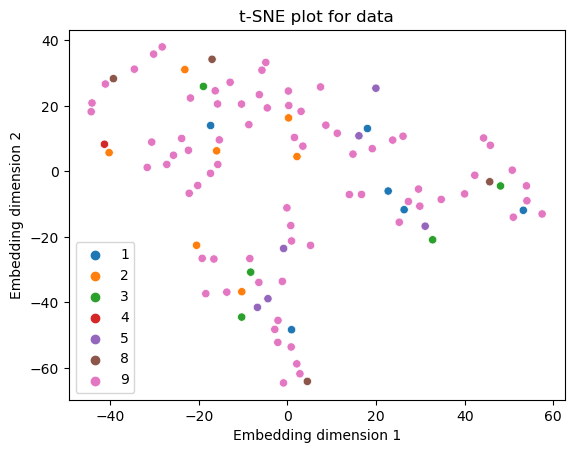

In [24]:
tsne_kwargs = {
    'perplexity': 6,
    'n_iter': 7500,
    'metric': 'cosine'
}

## PLOT BY THE WAY IN WHICH PEOPLE USE THE SAME REPLACED MODE AND CHECK THE SIMILARITY.

projections = generate_tsne_plots(demo_df, **tsne_kwargs)

In [25]:
# No stratification, pure random.
demo_df.reset_index(drop=False, inplace=True)
train, test = train_test_split(demo_df, test_size=0.2, random_state=SEED)

TRAIN_USERS = train.user_id.unique().tolist()
TEST_USERS = test.user_id.unique().tolist()

In [26]:
print(train.shape[0], test.shape[0])

81 21


In [27]:
# Ensuring that no user information is leaked across sets.
assert train.shape[0] + test.shape[0] == len(df.user_id.unique())

In [28]:
def evaluate_using_similarity(test_df, train_df, metric=SimilarityMetric.COSINE, **metric_kwargs):
    
    '''
    This method treats each user row as a 'fingerprint' (embedding vector). We assume that we
    have no idea about the test set labels. To find which replaced mode is most likely for the test
    users, we compute the cosine similarity of each test user against the users in the training set.
    For the most similar user, we use their target as a proxy for the test user's replaced mode.
    This operates on the following intuition: If User A and User B are similar, then their replaced
    modes are also similar.
    '''
    
    tr_targets = train_df.target.values
    tr = train_df.drop(columns=['target', 'user_id'], inplace=False).reset_index(drop=True, inplace=False)
    
    te_targets = test_df.target.values
    te = test_df.drop(columns=['target', 'user_id'], inplace=False).reset_index(drop=True, inplace=False)
    
    if metric == SimilarityMetric.COSINE:
        # Use cosine similarity to determine which element in the train set this user is closest to.
        # Offset the columns from the second entry to exclude the user_id column.
        # Returns a (n_te, n_tr) matrix.
        sim = cosine_similarity(te.values, tr.values)
        
        # Compute the argmax across the train set.
        argmax = np.argmax(sim, axis=1)

        # Index into the training targets to retrieve predicted label.
        y_test_pred = tr_targets[argmax]
        
    elif metric == SimilarityMetric.EUCLIDEAN:
        
        # Here, we choose the embedding with the smallest L2 distance.
        distances = euclidean_distances(te.values, tr.values)
        
        # We choose argmin
        argmin = np.argmin(distances, axis=1)
        
        # Index into the targets.
        y_test_pred = tr_targets[argmin]
    
    elif metric == SimilarityMetric.KNN:
        
        # Build the KNN classifier. By default, let it be 3.
        knn = KNeighborsClassifier(
            n_neighbors=metric_kwargs.pop('n_neighbors', 3),
            weights='distance',
            metric=metric_kwargs.pop('knn_metric', 'cosine'),
            n_jobs=os.cpu_count()
        )
        
        # Fit the data to the KNN model
        knn.fit(tr, tr_targets)
        
        y_test_pred = knn.predict(te)
    
    elif metric == SimilarityMetric.KMEANS:
        
        # Build the model.
        kmeans = KMeans(
            n_clusters=metric_kwargs.pop('n_clusters', 8),
            max_iter=metric_kwargs.pop('max_iter', 300),
            n_init='auto',
            random_state=SEED
        )
        
        # Fit the clustering model
        kmeans.fit(tr)
        
        # Construct the auxiliary df and merge with the training set.
        label_df = pd.DataFrame({'label': kmeans.labels_, 'target': tr_targets}, index=tr.index)
        
        # Now, perform an inference on the test set.
        predicted_labels = kmeans.predict(te)
        
        y_test_pred = []
        for prediction in predicted_labels:
            most_likely = label_df.loc[label_df.label == prediction, 'target'].value_counts().idxmax()
            y_test_pred.append(most_likely)
        
    else:
        raise NotImplementedError("Unknown similarity metric")
    
    
    f1 = f1_score(y_true=te_targets, y_pred=y_test_pred, average='weighted')
    print(f"Test F1 score using {metric.name} = {f1}")

In [29]:
for metric in [
    SimilarityMetric.COSINE, SimilarityMetric.EUCLIDEAN, SimilarityMetric.KNN, SimilarityMetric.KMEANS
]:
    evaluate_using_similarity(test, train, metric, n_clusters=3)

Test F1 score using COSINE = 0.42692939244663386
Test F1 score using EUCLIDEAN = 0.4126984126984127
Test F1 score using KNN = 0.4393241167434716
Test F1 score using KMEANS = 0.4733893557422969


Not bad - using just a simple random split gives us the following results:

$allCEO$:

```
Test F1 score using COSINE = 0.42692939244663386
Test F1 score using EUCLIDEAN = 0.4126984126984127
Test F1 score using KNN = 0.4393241167434716
Test F1 score using KMEANS = 0.4733893557422969
```

In [30]:
def custom_nll_scorer(clf, X, y):
    
    # [[yp1, yp2, yp3, ...], [yp1, yp3, ...]]
    y_pred = clf.predict_proba(X)
    
    return -log_loss(y_true=y, y_pred=y_pred, labels=sorted(np.unique(y)))

In [31]:
def estimate_using_model(train, test, **model_kwargs):
    
    cv = model_kwargs.pop('cv', None)
    n_splits = model_kwargs.pop('n_splits', 5)
    n_iter = model_kwargs.pop('n_iter', 500)
    
    if cv is None:
        # Define the train-val splitter.
        cv = KFold(n_splits=n_splits, shuffle=True, random_state=SEED)
    
    params = {
        'n_estimators': np.arange(100, 1001, 50),
        'max_depth': [i for i in range(5, 101, 5)],
        'ccp_alpha': np.linspace(0, 1, 10),
        'class_weight': ['balanced', 'balanced_subsample', None],
        'min_samples_split': np.arange(2, 25, 2),
        'min_samples_leaf': np.arange(1, 25)
    }
    
    rf = RandomForestClassifier(random_state=SEED)
    
    # Search over hparams to minimize negative log likelihood.  
#     clf = RandomizedSearchCV(
#         rf, params, n_iter=n_iter, scoring=custom_nll_scorer, 
#         n_jobs=os.cpu_count(), cv=cv, random_state=SEED,
#         verbose=0
#     )
    
    clf = RandomizedSearchCV(
        rf, params, n_iter=n_iter, scoring='f1_weighted', 
        n_jobs=cpu_count(), cv=cv, random_state=SEED,
        verbose=0
    )
    
    X_tr = train.drop(columns=['user_id', 'target'])
    y_tr = train.target.values.ravel()
    
    scorer = clf.fit(X_tr, y_tr)
    
    best_model = scorer.best_estimator_
    
    print(f"Best val score = {scorer.best_score_}")
    
    X_te = test.drop(columns=['user_id', 'target'])
    
    # Use the best model to compute F1 on the test set.
    test_f1 = f1_score(y_true=test.target.values, y_pred=best_model.predict(X_te), average='weighted')
    
    print(f"Test F1 = {test_f1}")
    
    return best_model

In [32]:
model = estimate_using_model(train, test)

Best val score = 0.653870145236778
Test F1 = 0.4733893557422969


Interesting! The model is slightly on par with K-Means!

## Experiment 2: Demographics with trip summaries

Now that we've performed experiments with solely demographic data, let's expand the feature set by including 
trip summary statistics. We would like this approach to do better than the aforementioned baselines.

In [41]:
demo_plus_trips = get_demographic_data(
    df, 
    trip_features=['mph', 'section_duration_argmax', 'section_distance_argmax', 'start_local_dt_hour', 'end_local_dt_hour']
)

In [42]:
demo_plus_trips.head()

,user_id,mph_mean_bicycling,mph_mean_car,mph_mean_transit,mph_mean_unknown,mph_mean_walking,mph_median_bicycling,mph_median_car,mph_median_transit,mph_median_unknown,mph_median_walking,mph_iqr_bicycling,mph_iqr_car,mph_iqr_transit,mph_iqr_unknown,mph_iqr_walking,section_duration_argmax_mean_bicycling,section_duration_argmax_mean_car,section_duration_argmax_mean_transit,section_duration_argmax_mean_unknown,section_duration_argmax_mean_walking,section_duration_argmax_median_bicycling,section_duration_argmax_median_car,section_duration_argmax_median_transit,section_duration_argmax_median_unknown,section_duration_argmax_median_walking,section_duration_argmax_iqr_bicycling,section_duration_argmax_iqr_car,section_duration_argmax_iqr_transit,section_duration_argmax_iqr_unknown,section_duration_argmax_iqr_walking,section_distance_argmax_mean_bicycling,section_distance_argmax_mean_car,section_distance_argmax_mean_transit,section_distance_argmax_mean_unknown,section_distance_argmax_mean_walking,section_distance_argmax_median_bicycling,section_distance_argmax_median_car,section_distance_argmax_median_transit,section_distance_argmax_median_unknown,section_distance_argmax_median_walking,section_distance_argmax_iqr_bicycling,section_distance_argmax_iqr_car,section_distance_argmax_iqr_transit,section_distance_argmax_iqr_unknown,section_distance_argmax_iqr_walking,start_local_dt_hour_mode_bicycling,start_local_dt_hour_mode_car,start_local_dt_hour_mode_transit,start_local_dt_hour_mode_unknown,start_local_dt_hour_mode_walking,end_local_dt_hour_mode_bicycling,end_local_dt_hour_mode_car,end_local_dt_hour_mode_transit,end_local_dt_hour_mode_unknown,end_local_dt_hour_mode_walking,coverage_bicycling,coverage_car,coverage_transit,coverage_unknown,coverage_walking,duration,distance,av_transit,av_no_trip,av_p_micro,av_s_micro,av_ridehail,av_unknown,av_walk,av_car,av_s_car,target
0,00db212b-c8d0-44cd-8392-41ab4065e603,6.239545,14.271367,16.895797,8.795720,1.829510,6.098018,12.315223,13.748353,7.372235,2.044505,1.796356,7.669828,18.274283,4.166229,1.097565,12.143593,16.171412,28.511443,25.603399,16.050633,9.901861,12.896737,19.895491,18.383817,11.879527,7.369607,10.658638,42.361577,9.815050,12.656333,1.324724,4.650185,10.723796,4.903672,0.435072,0.917019,2.259573,4.325583,2.021900,0.327231,0.902512,2.984623,15.810542,2.243013,0.317672,15.0,16.0,16.0,15.0,15.0,15.0,18.0,20.0,19.0,15.0,168,0.577488,0.065253,0.021207,0.336052,17.827598,3.486762,1,0,1,1,1,1,1,1,1,1
1,0154d714-3928-4c34-b865-e5a417cd48af,7.258829,16.707414,7.858924,11.252165,1.461767,7.422923,14.976323,5.173881,9.457230,1.442129,3.577637,10.730999,7.638888,8.972405,1.488708,16.175633,14.443387,8.807150,29.325692,20.568486,13.007849,11.101905,5.928156,21.190067,11.872480,9.095686,10.245300,6.172666,28.133073,15.518311,1.906896,4.595486,1.403190,6.730748,0.403743,1.479094,2.753808,0.389247,2.976015,0.225779,1.093852,3.797169,1.519272,5.904618,0.229162,9.0,16.0,8.0,8.0,8.0,7.0,16.0,8.0,8.0,20.0,32,0.833954,0.013837,0.044172,0.108036,15.860767,4.185754,1,0,1,1,1,1,1,1,1,9
2,03a395b4-d861-4757-bb84-32b4984559b0,8.400458,21.949909,12.512543,15.260936,1.762294,8.725430,21.171860,11.697772,13.190136,1.767112,2.942594,16.747731,9.494206,11.253264,1.390353,7.215576,19.063554,9.042499,3.948607,27.637920,5.710374,15.811629,1.798544,1.019833,15.008960,3.155090,14.843112,8.897862,5.068570,24.354036,1.007937,8.227581,3.100560,1.143773,0.588657,0.816212,5.555556,0.165721,0.169928,0.376107,0.097174,10.207405,2.961208,0.662906,0.433756,12.0,12.0,10.0,12.0,7.0,12.0,12.0,11.0,12.0,7.0,507,0.696151,0.003276,0.054054,0.246519,24.729501,5.846063,1,0,1,1,1,1,1,1,1,9
3,0a093cbd-b536-43af-b03d-293425e84c76,8.023209,12.519217,-1.000000,8.717745,1.520088,6.855097,11.158806,-1.000000,7.411870,1.635980,3.132708,8.243087,-1.000000,4.951139,1.519957,16.413152,29.697618,-1.000000,19.780111,30.175525,13.639533,24.230089,-1.000000,16.386455,20.406550,9.507167,24.436224,-1.000000,15.129912,21.678383,1.968588,6.684421,-1.000000,

In [43]:
train = demo_plus_trips.loc[demo_plus_trips.user_id.isin(TRAIN_USERS), :]
test = demo_plus_trips.loc[demo_plus_trips.user_id.isin(TEST_USERS), :]

print(train.shape[0], test.shape[0])

81 21


In [44]:
for metric in [
    SimilarityMetric.COSINE, SimilarityMetric.EUCLIDEAN, SimilarityMetric.KNN, SimilarityMetric.KMEANS
]:
    evaluate_using_similarity(test, train, metric, n_clusters=4)

Test F1 score using COSINE = 0.32098765432098775
Test F1 score using EUCLIDEAN = 0.36684303350970027
Test F1 score using KNN = 0.41269841269841273
Test F1 score using KMEANS = 0.4877344877344878


Great! Some improvement here and there.

$allCEO$
```
Test F1 score using COSINE = 0.32098765432098775
Test F1 score using EUCLIDEAN = 0.36684303350970027
Test F1 score using KNN = 0.41269841269841273
Test F1 score using KMEANS = 0.4877344877344878
```

In [45]:
# Now, we try with the model
estimate_using_model(train, test)

Best val score = 0.6326031937974128
Test F1 = 0.004329004329004328


RandomForestClassifier(ccp_alpha=0.2222222222222222,
                       class_weight='balanced_subsample', max_depth=25,
                       min_samples_leaf=5, min_samples_split=14,
                       n_estimators=700, random_state=13210)

Great! Compared to the previous model, we see definite improvements! I'm sure we can squeeze some more juice out of the models using fancy optimization, but as a baseline, these are good enough.


So, to recap:
$F1_{cosine} = 0.37$, $F1_{euclidean} = 0.33$, $F1_{knn} = 0.3$, $F1_{kmeans} = 0.36$, $F1_{RF} = 0.4215$

### Different groupings.

In [ ]:
# trip_features = ['mph', 'section_duration_argmax', 'section_distance_argmax', 'start:hour', 'end:hour']

# for group_mode in ['section_mode_argmax', 'section_distance_argmax', 'section_duration_argmax', 'duration', 'distance']:
    
#     if group_mode in trip_features:
#         _ = trip_features.pop(trip_features.index(group_mode))
    
#     exp_df = get_demographic_data(
#         df, 
#         trip_grouping=group_mode,
#         trip_features=trip_features,
#         use_qcut=True
#     )
    
#     train, test = train_test_split(exp_df, test_size=0.2, random_state=SEED)
    
#     for sim in [
#         SimilarityMetric.COSINE, SimilarityMetric.EUCLIDEAN, SimilarityMetric.KNN, SimilarityMetric.KMEANS
#     ]:
#         evaluate_using_similarity(test, train, sim, n_clusters=3)
    
#     # estimate_using_model(train, test, n_iter=200)
    
#     print(50*'=')

In [ ]:
_ = generate_tsne_plots(demo_plus_trips, perplexity=6, n_iter=7500)

# Multi-level modeling

In this approach, we want to piece together the similarity search and modeling processes. Here's a rough sketch of how it should be implemented:

1. For every user in the training set, build a model using their entire trip history.
2. Consolidate these user-level models in data structure, preferably a dictionary.
3. Now, when we want to perform inference on a new user with no prior trips, we use the similarity search to get the user ID in the training set who is the most similar to the user in question.
4. We retrieve the model for this corresponding user and perform an inference. The hypothesis is that since the two users are similar, their trip substitution patterns are also similar.

In [ ]:
def drop_columns(df: pd.DataFrame):
    to_drop = [
        'source', 'end_ts', 'end_fmt_time', 'end_loc', 'raw_trip', 'start_ts', 
        'start_fmt_time', 'start_loc', 'duration', 'distance', 'start_place', 
        'end_place', 'cleaned_trip', 'inferred_labels', 'inferred_trip', 'expectation',
        'confidence_threshold', 'expected_trip', 'user_input', 'start:year', 'start:month', 
        'start:day', 'start_local_dt_minute', 'start_local_dt_second', 
        'start_local_dt_weekday', 'start_local_dt_timezone', 'end:year', 'end:month', 'end:day', 
        'end_local_dt_minute', 'end_local_dt_second', 'end_local_dt_weekday', 
        'end_local_dt_timezone', '_id', 'metadata_write_ts', 'additions', 
        'mode_confirm', 'purpose_confirm', 'Mode_confirm', 'Trip_purpose', 
        'original_user_id', 'program', 'opcode', 'Timestamp', 'birth_year', 
        'available_modes', 'section_coordinates_argmax', 'section_mode_argmax'
    ]
    
    # Drop section_mode_argmax and available_modes.
    return df.drop(
        columns=to_drop, 
        inplace=False
    )

In [ ]:
def construct_model_dictionary(train: pd.DataFrame):
    
    def train_on_user(user_id: str):
        '''
        Given the training set and the user ID to query, filter the dataset and
        retain only the relevant trips. Then, create folds and optimize a model for this user.
        Return the trained model instance.
        '''
        
        user_data = train.loc[train.user_id == user_id, :].reset_index(drop=True)
        
        # Split user trips into train-test folds.
        u_train, u_test = train_test_split(user_data, test_size=0.2, shuffle=True, random_state=SEED)
        
        user_model = estimate_using_model(
            u_train, u_test, 
            n_iter=100
        )
        
        return user_model
    
    for user in train.user_id.unique():
        MODEL_DICT[user]['warm_start'] = train_on_user(user)
        print(50*'=')
    
    print("\nDone!")

## Warm start:

If the queried user has prior trips, we know that we we can harness the additional information. So if we encounter such a user, we will first find the most similar user (using only demographics). Once the most similar user is found, we query the trip model for the user and run inference through it.

## Cold start:

If the queried user has no prior trips, we will use the demo-only model. We first perform a similarity search and then run user inference through the demo-only model.

In [ ]:
class MultiLevelModel:
    def __init__(self, model_dict: Dict, train: pd.DataFrame, test: pd.DataFrame, **model_kwargs):
        
        self._demographics = [
            'primary_job_commute_time', 'income_category', 'n_residence_members', 'n_residents_u18', 
            'n_residents_with_license', 'n_motor_vehicles', 'available_modes', 'age', 'gender_Man', 
            'gender_Man;Nonbinary/genderqueer/genderfluid', 'gender_Nonbinary/genderqueer/genderfluid', 
            'gender_Prefer not to say', 'gender_Woman', 'gender_Woman;Nonbinary/genderqueer/genderfluid', 
            'has_drivers_license_No', 'has_drivers_license_Prefer not to say', 'has_drivers_license_Yes', 
            'has_multiple_jobs_No', 'has_multiple_jobs_Prefer not to say', 'has_multiple_jobs_Yes', 
            "highest_education_Bachelor's degree", 'highest_education_Graduate degree or professional degree', 
            'highest_education_High school graduate or GED', 'highest_education_Less than a high school graduate', 
            'highest_education_Prefer not to say', 'highest_education_Some college or associates degree', 
            'primary_job_type_Full-time', 'primary_job_type_Part-time', 'primary_job_type_Prefer not to say', 
            'primary_job_description_Clerical or administrative support', 'primary_job_description_Custodial', 
            'primary_job_description_Education', 'primary_job_description_Food service', 
            'primary_job_description_Manufacturing, construction, maintenance, or farming', 
            'primary_job_description_Medical/healthcare', 'primary_job_description_Other', 
            'primary_job_description_Professional, managerial, or technical', 
            'primary_job_description_Sales or service', 'primary_job_commute_mode_Active transport', 
            'primary_job_commute_mode_Car transport', 'primary_job_commute_mode_Hybrid', 
            'primary_job_commute_mode_Public transport', 'primary_job_commute_mode_Unknown', 
            'primary_job_commute_mode_WFH', 'is_overnight_trip', 'n_working_residents'
        ]
        
        assert all([c in test.columns for c in self._demographics]), "[test] Demographic features are missing!"
        assert all([c in train.columns for c in self._demographics]), "[train] Demographic features are missing!"
        
        self._mdict = model_dict
        self._train = train
        self._test = test
        self.metric = model_kwargs.pop('metric', SimilarityMetric.COSINE)
        
    
    def _phase1(self):
        
        tr = self._train.copy()
        te = self._test.copy()
        
        if tr.columns.isin(['user_id', 'target']).sum() == 2:
            tr = tr.drop(columns=['user_id', 'target']).reset_index(drop=True)
        
        if te.columns.isin(['user_id', 'target']).sum() == 2:
            te = te.drop(columns=['user_id', 'target']).reset_index(drop=True)

        te_users = self._test.user_id.tolist()

        if self.metric == SimilarityMetric.COSINE:

            sim = cosine_similarity(te.values, tr.values)

            # Compute the argmax across the train set.
            argmax = np.argmax(sim, axis=1)

            # Retrieve the user_id at these indices.
            train_users = self._train.loc[argmax, 'user_id']

        elif self.metric == SimilarityMetric.EUCLIDEAN:

            sim = euclidean_distances(te.values, tr.values)

            # Compute the argmin here!
            argmin = np.argmin(sim, axis=1)

            # Retrieve the train user_ids.
            train_users = self._train.loc[argmin, 'user_id']

        return pd.DataFrame({'test_user_id': te_users, 'train_user_id': train_users})
    
    
    def _phase2(self, sim_df: pd.DataFrame, cold_start: bool):
        
        prediction_df = list()
        
        # Now, we use the sim_df to run inference based on whether 
        for ix, row in sim_df.iterrows():
            train_user = row['train_user_id']
            
            # Retrieve the appropriate model.
            user_models = self._mdict.get(train_user, None)
            
            start_type = 'cold_start' if cold_start else 'warm_start'
            
            # which specific model?
            sp_model = user_models.get(start_type, None)
            
            # Now get the test user data.
            test_user = row['test_user_id']
            
            if cold_start:
                test_data = self._test.loc[self._test.user_id == test_user, self._demographics]
                test_data = test_data.iloc[0, :]
            else:
                test_data = self._test.loc[self._test.user_id == test_user, :]
            
            predictions = sp_model.predict(test_data)
            
            print(f"test: [{test_user}], predictions: {predictions}")
    
    
    def execute_pipeline(self, cold_start: bool = False):
        # For each test user, get the most similar train user.
        sim_df = self._phase1()
        
        predictions = self._phase2(sim_df, cold_start)

In [ ]:
# FULL DATA.
train = df.loc[df.user_id.isin(TRAIN_USERS), :]
test = df.loc[df.user_id.isin(TEST_USERS), :]

train_counts = train.user_id.value_counts()

In [ ]:
## We only want to train on users who have a good number of trips.
good_users = train_counts[train_counts >= 100].index

bad_users = train_counts[train_counts < 100].index

print(f"Number of users filtered out of training: {len(bad_users)}")

filtered_train = train.loc[train.user_id.isin(good_users), :]

In [ ]:
# Full data.

train_df = drop_columns(filtered_train)
test_df = drop_columns(test)

In [ ]:
print(train_df.shape, test_df.shape)

In [ ]:
model_dict = construct_model_dictionary(train_df)